# Отчёт по лабораторной работе №6 "Кластеризация"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from scipy.io import loadmat

def load_file(filename, keys=None):
    if keys is None:
        keys = ['X', 'y']
    mat = loadmat(filename)
    ret = tuple([mat[k].reshape(mat[k].shape[0]) if k.startswith('y') else mat[k] for k in keys])
    return ret

# 1. Загрузите данные ex6data1.mat из файла.

In [3]:
X, = load_file('ex6data1.mat', keys=['X'])
print(f'X shape: {X.shape}')

X shape: (50, 2)


# 2. Реализуйте функцию случайной инициализации K центров кластеров.

In [4]:
def initialize_cetroids(X, K):
    idx = np.random.randint(len(X), size=K)
    return X[idx, :]

# 2. Реализуйте функцию определения принадлежности к кластерам.

In [5]:
def get_clusters(X, centroids):
    c = np.zeros(len(X), dtype=int)

    for i, x in enumerate(X):
        c[i] = ((x - centroids)**2).sum(axis=1).argmin()

    return c

# 3. Реализуйте функцию пересчета центров кластеров.

In [6]:
def update_centroids(X, clusters, K):
    new_centroids = np.zeros((K, X.shape[1]))
    for k in range(K):
        if len(X[clusters == k]) == 0:
            continue
        new_centroids[k] = X[clusters == k].mean(axis=0)

    return new_centroids

# 4. Реализуйте алгоритм K-средних.

Для того чтобы реализовать алгоритм K-средних, для начала реализуем функцию стоимости.

In [7]:
def cost_func(X, c, centroids):
    M = X.shape[0]
    cost = 0
    for i in range(M):
        cost += ((X[i] - centroids[int(c[i])]) ** 2).sum()
    return cost / M

Далее реализуем алгоритм K-средних, где центры класстеров выбираеются случайным образом. Алгоритм работает итеративно до тех пор, пока разбиение входных данных на кластеры на текущей итерации не будет равнятся разбиению на прошлой итерации.

In [8]:
def k_means_algo(X, K):
    Result = namedtuple('Result', ['clusters', 'centroids_history'])
    centroids = initialize_cetroids(X, K)
    clusters = get_clusters(X, centroids)
    centroids_history = [centroids]

    while True:
        cur_centroids = update_centroids(X, clusters, K)
        cur_clusters = get_clusters(X, cur_centroids)
        centroids_history.append(cur_centroids)

        if (cur_clusters == clusters).all():
            break
        
        clusters = cur_clusters

    return Result(clusters=clusters, centroids_history=centroids_history)

Начальные значения центров класстеров могут быть выбраны не самым удачным образом, что не позволит функции стоимости достичь своего глобального минимума, а только лишь локального. В таком случае выбирается некоторое число итераций (в данном случае 100), и на каждой итерации алгоритм K-средних работает со своими начальными значениями центров класстеров. Это позволяет с большей вероятностью достичь минимизировать функцию стоимости к своему глобальному минимуму.

In [9]:
from collections import namedtuple

def k_means(X, K, max_iter=100):
    Result = namedtuple('Result', ['clusters', 'centroids', 'centroids_history', 'best_cost'])
    cur_cost = np.inf
    result = None

    for i in range(max_iter):
        centroids = initialize_cetroids(X, K)
        cur_result = k_means_algo(X, K)
        cost = cost_func(X, cur_result.clusters, cur_result.centroids_history[-1])

        if cost < cur_cost:
            result = cur_result
            cur_cost = cost

    return Result(clusters=result.clusters, centroids=result.centroids_history[-1],
                  centroids_history=result.centroids_history, best_cost=cur_cost)

# 6. Постройте график, на котором данные разделены на K=3 кластеров (при помощи различных маркеров или цветов), а также траекторию движения центров кластеров в процессе работы алгоритма.

In [10]:
result = k_means(X, 3)

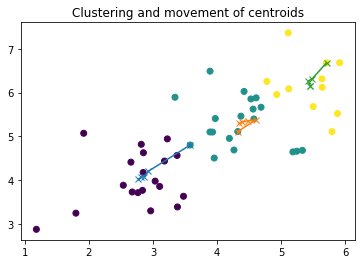

In [11]:
plt.scatter(X[:, 0], X[:, 1], c=result.clusters)
x1, y1, x2, y2, x3, y3 = [], [], [], [], [], []
for centr in result.centroids_history:
    x1.append(centr[0][0])
    y1.append(centr[0][1])
    x2.append(centr[1][0])
    y2.append(centr[1][1])
    x3.append(centr[2][0])
    y3.append(centr[2][1])
plt.plot(x1, y1, x2, y2, x3, y3, marker='x')
plt.title('Clustering and movement of centroids')
plt.show()

# 7. Загрузите данные bird_small.mat из файла.

In [12]:
A, = load_file('bird_small.mat', keys=['A'])
print(f'Image shape: {A.shape}')

Image shape: (128, 128, 3)


# 8. С помощью алгоритма K-средних используйте 16 цветов для кодирования пикселей.

In [13]:
def compress(A, n_colors=16):
    X = np.reshape(A, [A.shape[0] * A.shape[1], A.shape[2]])
    result = k_means(X, n_colors, max_iter=1)
    clusters = result.clusters
    new_colors = np.round(result.centroids).astype(np.uint8)

    image = X.copy()
    for i in range(X.shape[0]):
        image[i, :] = new_colors[clusters[i]]

    return image.reshape(A.shape)

In [16]:
compressed_A = compress(A)

# 9. Насколько уменьшился размер изображения? Как это сказалось на качестве?

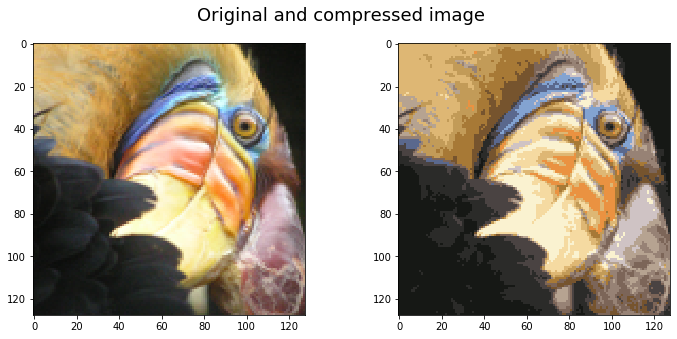

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=[12, 5])
fig.suptitle("Original and compressed image", fontsize=18)
axs[0].imshow(A)
axs[1].imshow(compressed_A)
plt.show()

Каждый пиксель сжатого изображения представляется 4-мя битами (0..15 в десятичной СС), поэтому сжатое изображение имеет размер `128*128 * 4 / 8` байт, что равняется `8192` байт.

Пиксель оригинальное изображение, в свою очередь представляется 8-ю битами, то есть 1-м байтов, а значит оно будет иметь размер `128*128` байт, что равняется `16384` байт. Следовательно сжатое изображение имеет в два раза меньший размер.

Как видим, качество изображения пострадало, однако по-прежнему легко различимо, что это попугай.

# 10. Реализуйте алгоритм K-средних на другом изображении.

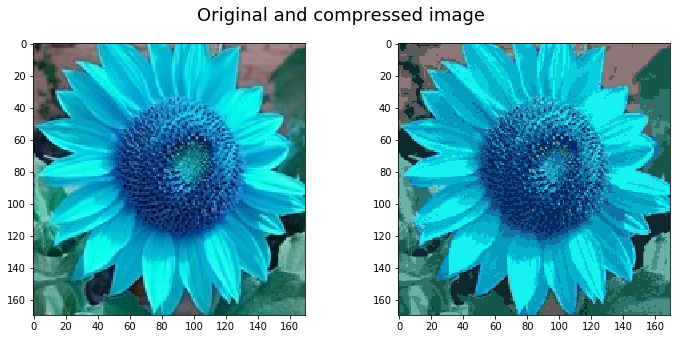

In [18]:
import cv2

img = cv2.imread('image_example.jpg', cv2.IMREAD_UNCHANGED)
compressed_img = compress(img)

fig, axs = plt.subplots(ncols=2, figsize=[12, 5])
fig.suptitle("Original and compressed image", fontsize=18)
axs[0].imshow(img)
axs[1].imshow(compressed_img)
plt.show()

# 11. Реализуйте алгоритм иерархической кластеризации на том же изображении. Сравните полученные результаты.

In [19]:
from sklearn.cluster import AgglomerativeClustering

def compress_hierarchical_clusters(img, n_colors=16):
    X = np.reshape(img, [img.shape[0] * img.shape[1], img.shape[2]])

    cluster = AgglomerativeClustering(n_clusters=n_colors, affinity='euclidean', linkage='ward')
    labels = cluster.fit_predict(X)
    centroids = update_centroids(X, labels, n_colors).reshape((n_colors, 3))
    new_colors = np.round(centroids).astype(np.uint8)

    image = X.copy()
    for i in range(X.shape[0]):
        image[i, :] = new_colors[labels[i]]

    return image.reshape(img.shape)

In [20]:
compressed_img_hier_cl = compress_hierarchical_clusters(img)

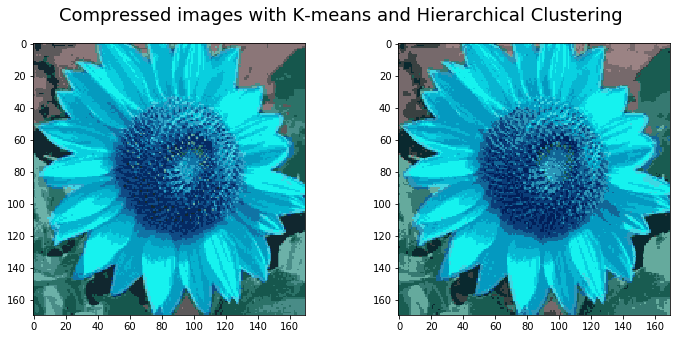

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=[12, 5])
fig.suptitle("Compressed images with K-means and Hierarchical Clustering", fontsize=18)
axs[0].imshow(compressed_img)
axs[1].imshow(compressed_img_hier_cl)
plt.show()

В данном примере используется агломеративный метод иерархической кластеризации, то есть метод, при котором новые кластеры создаются путем объединения более мелких кластеров и, таким образом, дерево создается от листьев к стволу.

Как видим, результат получились достаточно схож с результатом алгоритма K-средних. Это связано с тем, что был использован метод Уорда, с помощью которого расстояние между кластерами высчитывается на основе дисперсии, то есть минимизируется квадрат расстояния между объектами. А это, в свою очередь, очень похоже на метод, с помощью которого минимизируется функция стоимости в реализованном алгоритме K-средних.